
# Ejercicio: Regresión Lineal con datos agrícolas

En este notebook aplicarás **Regresión Lineal** para predecir la variable `Producción_Ton` a partir de otras variables agrícolas y económicas.

📂 **Base de datos**: `datos_regresion_lineal_agricola.xlsx`  
- Hoja **Datos**: registros.  
- Hoja **Diccionario**: descripción de variables.

---

## Objetivo del ejercicio
- Construir un modelo de **Regresión Lineal** con scikit-learn.  
- Aplicar buenas prácticas de preprocesamiento, entrenamiento, evaluación y visualización.  
- Interpretar resultados en el contexto agrícola.

**Nota**: este notebook contiene consignas y celdas vacías para que los alumnos lo completen.


## 1) Preparación de entorno

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

## 2) Cargar y explorar los datos

In [16]:
# Ruta al archivo Excel generado previamente
file_path = "ejercicio_1_datos_regresion_lineal_agricola.xlsx"

# Cargar datos de la hoja 'Datos'
df = pd.read_excel(file_path, sheet_name="Datos")

# Mostrar primeras filas
df.head()

,Año,Mes,Región,Cultivo,Superficie_Ha,Producción_Ton,Precio_Ton,Costos_Insumos,Ingresos,Utilidad
0,2023,1,Norte,Maíz,122,749,316.95,12541,237319.70,224778.70
1,2023,1,Norte,Soja,141,422,273.40,2574,115405.98,112831.98
2,2023,1,Norte,Trigo,107,328,311.12,2543,101962.95,99419.95
3,2023,1,Norte,Manzana,363,2874,274.87,5428,789881.63,784453.63
4,2023,1,Norte,Tomate,211,1446,131.99,2363,190802.69,188439.69


In [17]:
# Información general de las columnas
df.info()

# Estadísticas descriptivas
df.describe(include="all").T

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 480 entries, 0 to 479
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Año             480 non-null    int64  
 1   Mes             480 non-null    int64  
 2   Región          480 non-null    object 
 3   Cultivo         480 non-null    object 
 4   Superficie_Ha   480 non-null    int64  
 5   Producción_Ton  480 non-null    int64  
 6   Precio_Ton      480 non-null    float64
 7   Costos_Insumos  480 non-null    int64  
 8   Ingresos        480 non-null    float64
 9   Utilidad        480 non-null    float64
dtypes: float64(3), int64(5), object(2)
memory usage: 37.6+ KB


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Año,480.0,NaN,NaN,NaN,2023.5,0.500522,2023.0,2023.0,2023.5,2024.0,2024.0
Mes,480.0,NaN,NaN,NaN,6.5,3.455654,1.0,3.75,6.5,9.25,12.0
Región,480,4,Norte,120,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Cultivo,480,5,Maíz,96,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Superficie_Ha,480.0,NaN,NaN,NaN,253.041667,141.376776,20.0,137.0,245.0,378.25,499.0
Producción_Ton,480.0,NaN,NaN,NaN,1613.71875,1157.53085,48.0,677.25,1314.5,2412.5,5403.0
Precio_Ton,480.0,NaN,NaN,NaN,254.586896,74.45154,100.09,193.8125,265.365,312.11,397.48
Costos_Insumos,480.0,NaN,NaN,NaN,10438.29375,5545.255615,1543.0,5399.5,10356.5,15137.25,19957.0
Ingresos,480.0,NaN,NaN,NaN,379991.904521,263489.847762,17546.34,179413.99,334503.955,515130.73,1451367.44
Utilidad,480.0,NaN,NaN,NaN,369553.610771,263795.833364,240.34,167052.425,322863.2,504072.8175,1442403.44


## 3) Análisis exploratorio (EDA)

In [18]:

# Calcula estadísticas agrupadas por 'Cultivo' y 'Región' (ejemplo: media de Producción_Ton)
# Estadísticas agrupadas por cultivo y región
group_stats = df.groupby(["Cultivo", "Región"]).agg({
    "Producción_Ton": ["mean", "std", "min", "max"],
    "Superficie_Ha": ["mean", "std"],
    "Precio_Ton": ["mean"]
}).round(2)
group_stats


Producción_Ton                     Superficie_Ha          \
                          mean      std  min   max          mean     std   
Cultivo Región                                                             
Manzana Austral        2200.25  1522.48  382  5150        239.88  164.65   
        Centro         2652.50  1279.63  307  5403        283.29  135.27   
        Norte          2360.12  1441.66  219  5156        263.38  155.69   
        Sur            2350.75  1194.25  232  4516        230.04  100.29   
Maíz    Austral        1645.38  1016.75  224  3596        232.92  142.61   
        Centro         1697.88  1112.77  183  3480        225.42  145.25   
        Norte          1648.50  1045.71  163  3723        235.46  145.42   
        Sur            1810.17   958.10  451  3614        230.79  124.50   
Soja    Austral         702.17   366.33  110  1580        236.08  133.31   
        Centro          699.17   471.35   79  2024        219.88  130.06   
        Norte           849.79   479.63   64  1549        267.79  146.04   
        Sur            1052.04   580.23   48  2113        294.08  152.00   
Tomate  Austral        2257.38  1113.10  184  3918        290.04  145.24   
        Centro         2071.50  1380.71  209  4738        257.96  163.15   
        Norte          1778.83  1070.78  253  3579        234.79  141.01   
        Sur            2302.17  1304.30  219  4369        271.12  148.56   
Trigo   Austral         991.79   515.79   72  1981        260.42  142.30   
        Centro         1052.50   663.75  131  2116        246.12  147.64   
        Norte           981.62   453.84  328  1726        260.83  124.90   
        Sur            1169.88   665.07  134  2398        280.54  147.11   

                Precio_Ton  
                      mean  
Cultivo Región              
Manzana Austral     215.31  
        Centro      223.98  
        Norte       230.65  
        Sur         230.55  
Maíz    Austral     274.05  
        Centro      267.95  
        Norte       273.94  
        Sur         260.95  
Soja    Austral     323.45  
        Centro      337.10  
        Norte       317.02  
        Sur         346.92  
Tomate  Austral     141.95  
        Centro      149.35  
        Norte       146.76  
        Sur         145.91  
Trigo   Austral     286.31  
        Centro      306.33  
        Norte       314.82  
        Sur         298.44

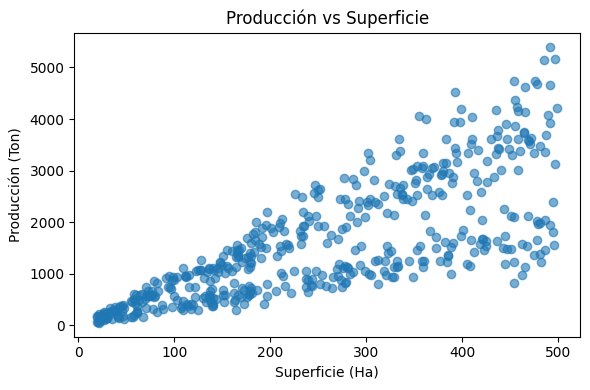

In [19]:

# Realiza al menos un gráfico exploratorio (ej: Producción_Ton vs Superficie_Ha)
# Dispersión Producción_Ton vs Superficie_Ha
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.scatter(df["Superficie_Ha"], df["Producción_Ton"], alpha=0.6)
plt.xlabel("Superficie (Ha)")
plt.ylabel("Producción (Ton)")
plt.title("Producción vs Superficie")
plt.tight_layout()
plt.show()


## 4) Definición de variables para el modelo

In [20]:

# Define X con variables: Año, Mes, Región, Cultivo, Superficie_Ha, Precio_Ton, Costos_Insumos
# Define y como Producción_Ton
feature_cols = ["Año", "Mes", "Región", "Cultivo", "Superficie_Ha", "Precio_Ton", "Costos_Insumos"]
target_col = "Producción_Ton"

X = df[feature_cols].copy()
y = df[target_col].copy()


## 5) División de datos en Train/Test

In [21]:

# Separa en entrenamiento y prueba (80/20)
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


## 6) Preprocesamiento

In [22]:

# Crea transformadores para variables numéricas (imputer + scaler) y categóricas (imputer + onehot)
# Une ambos en un ColumnTransformer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

numeric_features = ["Año", "Mes", "Superficie_Ha", "Precio_Ton", "Costos_Insumos"]
categorical_features = ["Región", "Cultivo"]

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)


## 7) Entrenamiento del modelo

In [23]:

# Construye un Pipeline con preprocesamiento + LinearRegression
# Ajusta el modelo con .fit()
from sklearn.linear_model import LinearRegression

model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", LinearRegression())
])

model.fit(X_train, y_train)
y_pred = model.predict(X_test)


## 8) Evaluación

In [24]:

# Calcula métricas: MAE, RMSE, R2
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = float(np.sqrt(mse))
r2 = r2_score(y_test, y_pred)


In [25]:

# Imprime las métricas con formato legible
print(f"MAE : {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2  : {r2:.3f}")


MAE : 305.79
RMSE: 392.03
R2  : 0.877


## 9) Gráfico Predicho vs Real

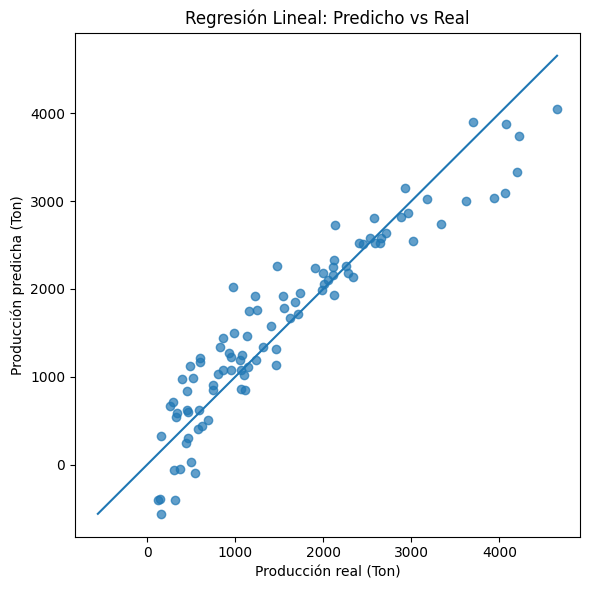

In [26]:

# Genera gráfico de dispersión de y_test vs y_pred y añade línea diagonal
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.7)
min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val])
plt.xlabel("Producción real (Ton)")
plt.ylabel("Producción predicha (Ton)")
plt.title("Regresión Lineal: Predicho vs Real")
plt.tight_layout()
plt.show()


## 10) Diagnóstico de residuos (opcional)

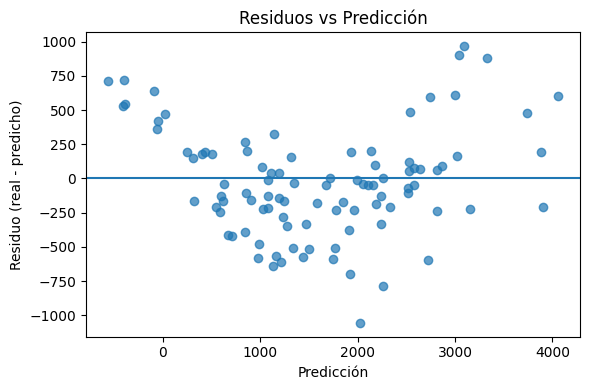

In [27]:

# Calcula residuos (y_test - y_pred) y grafícalos contra y_pred
residuals = y_test - y_pred

plt.figure(figsize=(6,4))
plt.scatter(y_pred, residuals, alpha=0.7)
plt.axhline(0)
plt.xlabel("Predicción")
plt.ylabel("Residuo (real - predicho)")
plt.title("Residuos vs Predicción")
plt.tight_layout()
plt.show()


## 11) Interpretación de coeficientes (opcional)

In [28]:

# Extrae coeficientes del modelo lineal y relaciónalos con las variables
# Recuperar nombres de columnas tras One-Hot
ohe = model.named_steps["preprocessor"].named_transformers_["cat"].named_steps["onehot"]
cat_names = list(ohe.get_feature_names_out(["Región", "Cultivo"]))
num_names = ["Año", "Mes", "Superficie_Ha", "Precio_Ton", "Costos_Insumos"]
feature_names = num_names + cat_names

linreg = model.named_steps["model"]
coef_series = pd.Series(linreg.coef_, index=feature_names).sort_values(ascending=False)

# Mostrar top positivos y negativos
top_pos = coef_series.head(10)
top_neg = coef_series.tail(10)

print("Top 10 coeficientes positivos:\n")
print(top_pos)

print("\nTop 10 coeficientes negativos:\n")
print(top_neg)


Top 10 coeficientes positivos:

Superficie_Ha      891.532274
Cultivo_Manzana    795.561000
Cultivo_Tomate     451.388273
Cultivo_Maíz       230.897835
Región_Centro       74.383921
Mes                 52.206461
Región_Sur          40.707735
Precio_Ton          16.788792
Año                 12.034002
Costos_Insumos       1.048593
dtype: float64

Top 10 coeficientes negativos:

Región_Centro      74.383921
Mes                52.206461
Región_Sur         40.707735
Precio_Ton         16.788792
Año                12.034002
Costos_Insumos      1.048593
Región_Austral    -26.661371
Región_Norte      -88.430285
Cultivo_Trigo    -647.698814
Cultivo_Soja     -830.148295
dtype: float64


## 12) Conclusiones


Escribe una interpretación en 5–8 líneas sobre:
- Qué tan bien funciona el modelo (según métricas y gráficos).
- Limitaciones observadas.
- Posibles mejoras (variables derivadas, otros algoritmos).
